In [5]:
import warnings
import joblib
import matplotlib.pyplot as plt
import math
import pandas as pd
import torch
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%aimport Weather
%aimport Load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Location and Data Collection

In [ ]:
from LocationPicker import pick_location
# Location
location = 'Houston'
dic = pick_location(location)
region, n_houses, w_cols, w_url, demand_scale_rate = dic['region'], \
    dic['n_households'], dic['weather_columns'],\
    dic['weather_url'],dic['demand_downscale_rate'],
# Training period for weather data
date_from_train, date_to_train = '01-01-2015', '12-31-2024'

#### 1.1. ERCOT Load Data
Load demand from: https://www.ercot.com/gridinfo/load/load_hist/
COAST Counties: Victoria, Calhoun, Wharton, Galveston, Harris, Jackson, Matagorda, Brazoria, Fort Bend,
Chambers, Montgomery, Waller (https://www.ercot.com/news/mediakit/maps)

SCENT counties: Burnet, Williamson, Milam, Burleson, Washington, Austin, Colorado, Fayette, Bastrop, Travis, Blanco, Hays, Caldwell, Gonzales, De Witt, Karnes, Wilson, Bexar, Medina, Kendall, Comal, Guadalupe, Bandera, Lavaca, Lee (https://www.ercot.com/news/mediakit/maps)

Important: Ercot data for 2015 does not include consumption at time 00:00 AM for 01/01/2015. It is included in data for 2014, the last row.

In [ ]:
from Load import *

# Get load data for desired range
train_demand_path = f'Data/Native_Load/Native_Load({date_from_train})({date_to_train})train.csv'
l_df = get_demand(date_from=date_from_train, date_to=date_to_train)
l_df.to_csv(train_demand_path, index=False)

#### 1.2. Weather
Weather historical data from: https://www.wunderground.com/history/
Units of data: Temperature (F), Humidity (100%), Wind (mph), Pressure (in), Precipitation (in), Condition (str)

In [ ]:
from Weather import *

# Call web-scrapping function
w_df = get_weather_data(
    loc=location,
    date_from=date_from_train,
    date_to=date_to_train,
    url=w_url,
    columns=w_cols)

In [ ]:
# Store if all data collected
w_df.to_csv(f"Data/Weather/{location}_weather({date_from_train})({date_to_train})train.csv", index=False)

In [131]:
# Refine data
w_df = pd.read_csv(f'Data/Weather/{location}_weather({date_from_train})({date_to_train})train.csv')

w_df = refine_weather_data(w_df, date_from_train, date_to_train)

w_df.to_csv(f'Data/{location}_weather({date_from_train})({date_to_train})refined.csv', index=False)

### 2. Aggregate Load Demand and Weather

In [7]:
from Weather import *
from Load import *

def concat_weather_demand(w_df, l_df, scaler=None):
    # Aggregate datasets
    concat_df = pd.concat((w_df, l_df), axis=1)
    concat_df['Date'] = pd.to_datetime(concat_df['Date']).dt.strftime('%m/%d/%Y')

    # Preprocess weather data
    concat_df = categorize_weather(concat_df)

    # Scale demand
    concat_df = scale_demand(concat_df, demand_scale_rate, n_houses, region)

    # Build date features
    concat_df = get_time_features(concat_df)

    # Standard scaling and saving info
    cols_to_scale = ['Temperature', 'Wind', 'Pressure', 'Precipitation', 'Demand']
    if scaler is None:
        scaler = StandardScaler()
        concat_df[cols_to_scale] = scaler.fit_transform(concat_df[cols_to_scale])
        target_stats = (scaler.mean_[-1], scaler.var_[-1])  # (u, s)
    else:
        concat_df[cols_to_scale] = scaler.transform(concat_df[cols_to_scale])
        target_stats = None
    concat_df = pd.DataFrame(concat_df)
    return concat_df, scaler, target_stats

In [8]:
# Load data
weather_df = pd.read_csv(f'Data/{location}_weather({date_from_train})({date_to_train})refined.csv')
demand_df = pd.read_csv(f'Data/native_load_2015_2024.csv')
train_df, scaler, target_stats = concat_weather_demand(weather_df, demand_df[region])
joblib.dump([target_stats, scaler], 'train_scaler.pkl')

['train_scaler.pkl']

In [9]:
# Save prepared data for train
train_df.to_csv(f'Data/{location}_ready_for_train.csv', index=False)

### 3. Train Model
Consumption is target. Other features, including consumption, are for input to Seq2Seq model

In [ ]:
train_df = pd.read_csv(f'Data/{location}_ready_for_train.csv')
y = train_df['Demand'].values            # must be arrays
X = train_df.values                      # must be arrays
input_dim = len(train_df.columns)
order_of_features = train_df.columns

In [39]:
# data is saved in a csv file and is then passed as file name to the model
args = {
    'n_epochs': 100,
    'batch_size_train': 64,
    'batch_size_val': 64,
    'n_batches_train': 10,
    'n_batches_val': 10,
    'input_seq_len': 24*2,
    'output_seq_len': 24,
    'input_dim': input_dim,
    'output_dim': 3,
    'n_layers': 3,
    'enc_hidden_dim': 64,
    'dec_hidden_dim': 64,
    'dropout': 0.1,
    'initial_lr': 0.001,
    'clip': 5,
    'initial_tf_ratio': 0.8,
    'quantiles': [0.1, 0.5, 0.9],
    'valid_years': 1,
    'location': location,
    'target_mean': target_stats[0],
    'target_std': math.sqrt(target_stats[1]),
    'patience': 20,
    'min_delta': 0.001
}
name =  f"({args['location']})" + \
        f"T{args['input_seq_len']}-" \
        f"L{args['n_layers']}-" \
        f"HD{args['enc_hidden_dim']}"

In [40]:
from Seq2Seq_RNN_Attention import Seq2SeqModel
import time

model = Seq2SeqModel(args=args, name=name)

start = time.time()
model.start_training(X, y)
elapsed = time.time()-start

print(f'Training Time: {int(elapsed/60)} min {elapsed % 60:0.1f}s')

The model has 288,390 trainable parameters
Initial learning rate is 0.001
Epoch: 1/100  5.52s  T-Loss: 0.6822  V-Loss: 0.6417   T-Cert.: 0.65   V-Cert.: 0.88
Epoch: 2/100  7.44s  T-Loss: 0.5078  V-Loss: 0.6480   T-Cert.: 0.81   V-Cert.: 0.73
Epoch: 3/100  7.66s  T-Loss: 0.4970  V-Loss: 0.5486   T-Cert.: 0.74   V-Cert.: 0.80
Epoch: 4/100  6.87s  T-Loss: 0.4634  V-Loss: 0.5267   T-Cert.: 0.81   V-Cert.: 0.81
Epoch: 5/100  6.94s  T-Loss: 0.4526  V-Loss: 0.5323   T-Cert.: 0.81   V-Cert.: 0.82
Epoch: 6/100  7.22s  T-Loss: 0.4397  V-Loss: 0.5075   T-Cert.: 0.79   V-Cert.: 0.81
Epoch: 7/100  7.31s  T-Loss: 0.4345  V-Loss: 0.5177   T-Cert.: 0.79   V-Cert.: 0.81
Epoch: 8/100  7.20s  T-Loss: 0.4375  V-Loss: 0.5264   T-Cert.: 0.80   V-Cert.: 0.81
Epoch: 9/100  7.28s  T-Loss: 0.4205  V-Loss: 0.5032   T-Cert.: 0.80   V-Cert.: 0.81
Epoch: 10/100  7.24s  T-Loss: 0.4233  V-Loss: 0.4766   T-Cert.: 0.79   V-Cert.: 0.82
Epoch: 11/100  7.26s  T-Loss: 0.4371  V-Loss: 0.5006   T-Cert.: 0.79   V-Cert.: 0.81


### 4. Inference

In [ ]:
from Weather import *
from Load import *
# Collect weather data
date_from_inf, date_to_inf = '01-01-2025', '01-07-2025'
weather_inf = get_weather_data(
    loc=location,
    date_from=date_from_inf,
    date_to=date_to_inf,
    url=w_url,
    columns=w_cols)

100%|██████████| 7/7 [02:23<00:00, 20.45s/it]


Data saved for Houston from 01-01-2025 to 01-07-2025


In [ ]:
# Store if all data collected
path_inf = f"Data/Weather/{location}_weather({date_from_inf})({date_to_inf})inf.csv"
weather_inf.to_csv(path_inf, index=False)

In [24]:
# Import and refin weather
w_df_inf = pd.read_csv(f'Data/Weather/{location}_weather({date_from_inf})({date_to_inf})inf.csv')
w_df_inf = refine_weather_data(w_df_inf, date_from_inf, date_to_inf)

# Get demand data
d_df_inf = get_demand(date_from_inf, date_to_inf)

# Concat datasets
target_stats, scaler = joblib.load('train_scaler.pkl')
inf_df, _ , _ = concat_weather_demand(w_df_inf, d_df_inf[region], scaler)

# Reordering features
inf_df = inf_df.reindex(columns=order_of_features)

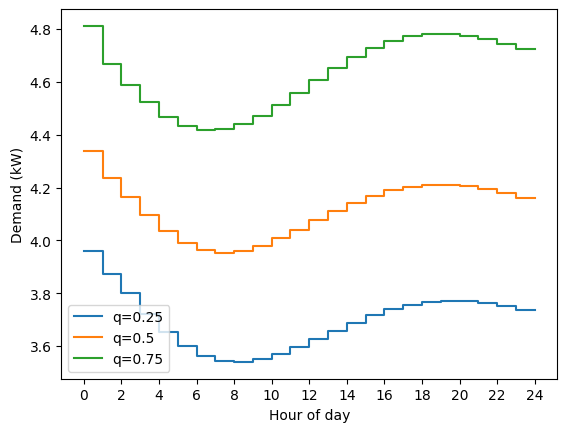

In [25]:
# Predict
infer_X = inf_df.values
infer_y = inf_df['Demand'].values
infer_pred = model.predict(infer_X, nn_param=f"Models/{name}.pt")
infer_pred = infer_pred[0, :, :] * target_stats[1] + target_stats[0]

# Preprocess for step plot
infer_pred = torch.cat((infer_pred, infer_pred[-1, :].repeat(1, 1)), dim=0)

# Plot
plt.step(range(25), infer_pred[:, 0], where='post', label='q=0.25')
plt.step(range(25), infer_pred[:, 1], where='post', label='q=0.5')
plt.step(range(25), infer_pred[:, 2], where='post', label='q=0.75')
plt.xlabel('Hour of day')
plt.ylabel('Demand (kW)')
plt.xticks(range(0, 25, 2), [str(h) for h in range(0, 25, 2)])
plt.legend()
plt.show()

In [ ]:
# Save predictions
pd.DataFrame(infer_pred.squeeze(0), columns=args['quantiles']).to_csv(f'Data/{name}-Scenarios.csv', index=False)